# Analyses of latent representations of LINCS L1000 expression profiles learned with VAE and S-VQ-VAE

In [2]:
from __future__ import division
import sys
import math
import random
import time
import operator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmapPy as cp
from cmapPy.pandasGEXpress.parse import parse
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data as Tdata
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import gaussian_kde
import scipy
from scipy import spatial
from scipy import stats
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

Major cell lines that contain over 10,000 samples from GSE70138 and GSE106127.

In [3]:
cellLineNameSM = set(["A375", "HA1E", "HELA", "HT29", "MCF7", "PC3", "YAPC"])
cellLineNameGP = set(["A375", "A549", "HA1E", "HCC515", "HEPG2", "HT29", "MCF7", "PC3", "VCAP"])

## Load GSE70138 small molecular L1000 data

### Load signature metadata

In [4]:
sigFileNameSM = "../Data/L1000/GSE70138_Broad_LINCS_sig_info_2017-03-06.txt"
sigInfoSM = pd.read_csv(sigFileNameSM, sep = "\t")
cellLineInfoSM = sigInfoSM[sigInfoSM["cell_id"].isin(cellLineNameSM)]
cellLineSigSM = cellLineInfoSM["sig_id"]
cellLinePertSM = cellLineInfoSM["pert_id"]
cellLinePertTypeSM = cellLineInfoSM["pert_type"]
print(sigInfoSM.shape)
print(cellLineInfoSM.shape)

(118050, 8)
(85183, 8)


In [5]:
pertDicSM = {}
pertArraySM = cellLinePertSM.values
for i in range(len(pertArraySM)):
    pertSM = pertArraySM[i]
    c = pertDicSM.setdefault(pertSM, 0)
    pertDicSM[pertSM] = c + 1
print("The number of perturbagens: " + str(len(pertDicSM)))

The number of perturbagens: 1797


### Load gene information

In [6]:
geneFileNameSM = "../Data/L1000/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt"
geneInfoSM = pd.read_csv(geneFileNameSM, sep = "\t")
lmInfoSM = geneInfoSM["pr_gene_id"][geneInfoSM["pr_is_lm"] == 1].astype(str) # landmark genes only
print(geneInfoSM.shape)
print(lmInfoSM.shape)

(12328, 5)
(978,)


### Load perturbagen class (PCL) information

In [7]:
pclFileNameSM = "../Data/YX_Data/pcl_information.csv"
pertClassDicSM = {}
classDicSM = {}
pertCountSM = 0
with open(pclFileNameSM, "r") as myfile:
    for line in myfile.readlines():
        if not len(line):
            continue
        pertCountSM += 1
        line = line.strip()
        spline = line.split(',')
        pertClassDicSM[spline[0]] = spline[1]
        c = classDicSM.setdefault(spline[1], 0)
        classDicSM[spline[1]] = c + 1
print("The number of perturbagens with class information: " + str(pertCountSM))
print("The number of PCL: " + str(len(classDicSM)))
print(sorted(classDicSM.items(), key = operator.itemgetter(1), reverse = True)[0])

The number of perturbagens with class information: 991
The number of PCL: 171
('CP_GLUCOCORTICOID_RECEPTOR_AGONIST', 44)


In [8]:
overlapPertDicSM = {}
overLapPertClassDicSM = {}
overLapPertClassCountSM = {}
for pert in pertDicSM:
    if pert in pertClassDicSM:
        overlapPertDicSM[pert] = 1
        c = overLapPertClassDicSM.setdefault(pertClassDicSM[pert], 0)
        overLapPertClassDicSM[pertClassDicSM[pert]] = c + 1
        c = overLapPertClassCountSM.setdefault(pertClassDicSM[pert], 0)
        overLapPertClassCountSM[pertClassDicSM[pert]] = c + pertDicSM[pert]
print("The number of perturbagens with class information: " + str(len(overlapPertDicSM)))
print("The number of classes of overlap perturbagens: " + str(len(overLapPertClassDicSM)))
print(sorted(overLapPertClassDicSM.items(), key = operator.itemgetter(1), reverse = True)[0])
print(sorted(overLapPertClassCountSM.items(), key = operator.itemgetter(1), reverse = True)[0])

The number of perturbagens with class information: 204
The number of classes of overlap perturbagens: 75
('CP_DOPAMINE_RECEPTOR_ANTAGONIST', 12)
('CP_PROTEASOME_INHIBITOR', 2352)


### Load and process all L1000 data

In [9]:
L1000FileNameSM = "../Data/L1000/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx"
gctoo_cellLineSM = parse(L1000FileNameSM, cid = cellLineSigSM, rid = lmInfoSM)
print(gctoo_cellLineSM.data_df.shape)
print(max(gctoo_cellLineSM.data_df.max()))
print(min(gctoo_cellLineSM.data_df.min()))

(978, 85183)
10.0000019073
-10.0000019073


In [10]:
expDataSM = torch.Tensor(gctoo_cellLineSM.data_df.transpose().values.astype(np.float32))
expDatasetSM = Tdata.TensorDataset(expDataSM)

### Load and process L1000 data with PCL information

In [11]:
cellLineInfoSMC = cellLineInfoSM[cellLineInfoSM["pert_id"].isin(pertClassDicSM)]
cellLineSigSMC = cellLineInfoSMC["sig_id"]
gctoo_cellLineSMC = parse(L1000FileNameSM, cid = cellLineSigSMC, rid = lmInfoSM)
print(cellLineInfoSMC.shape)
print(gctoo_cellLineSMC.data_df.shape)

(12079, 8)
(978, 12079)


In [12]:
expDataSMC = torch.Tensor(gctoo_cellLineSMC.data_df.transpose().values.astype(np.float32))
pertClassTargetDicSM = {}
pertClassTargetIndexSM = 0
for pert in overlapPertDicSM:
    if pertClassDicSM[pert] not in pertClassTargetDicSM:
        pertClassTargetDicSM[pertClassDicSM[pert]] = pertClassTargetIndexSM
        pertClassTargetIndexSM += 1
pertClassTargetArraySM = np.zeros((expDataSMC.size()[0]))
targetIndex = 0
for sig in gctoo_cellLineSMC.data_df.transpose().index.values:
    pert = cellLineInfoSMC[cellLineInfoSMC["sig_id"] == sig]["pert_id"].values[0]
    pertClass = pertClassDicSM[pert]
    pertClassIndex = pertClassTargetDicSM[pertClass]
    pertClassTargetArraySM[targetIndex] = pertClassIndex
    targetIndex += 1
nClassSMC = len(pertClassTargetDicSM)
print("The number of PCL: " + str(nClassSMC))
pertClassTargetSM = torch.LongTensor(pertClassTargetArraySM)

The number of PCL: 75


In [13]:
expDatasetSMC = Tdata.TensorDataset(expDataSMC, pertClassTargetSM)

### Load and process L1000 data without perturbagen 'MG-31' and 'bortezomib'

In [14]:
excludePertDicSM = {'MG-132': 1, 'bortezomib': 1}
cellLineInfoSMNP = cellLineInfoSM[~cellLineInfoSM["pert_iname"].isin(excludePertDicSM)]
cellLineSigSMNP = cellLineInfoSMNP["sig_id"]
gctoo_cellLineSMNP = parse(L1000FileNameSM, cid = cellLineSigSMNP, rid = lmInfoSM)
print(cellLineInfoSMNP.shape)
print(gctoo_cellLineSMNP.data_df.shape)

(80534, 8)
(978, 80534)


In [15]:
expDataSMNP = torch.Tensor(gctoo_cellLineSMNP.data_df.transpose().values.astype(np.float32))
expDatasetSMNP = Tdata.TensorDataset(expDataSMNP)

### Load and process L1000 data with PCL information and without perturbagen 'MG-31'

In [16]:
excludePertDicSMC = {'MG-132': 1}
cellLineInfoSMCNP = cellLineInfoSMC[~cellLineInfoSMC["pert_iname"].isin(excludePertDicSMC)]
cellLineSigSMCNP = cellLineInfoSMCNP["sig_id"]
gctoo_cellLineSMCNP = parse(L1000FileNameSM, cid = cellLineSigSMCNP, rid = lmInfoSM)
print(cellLineInfoSMCNP.shape)
print(gctoo_cellLineSMCNP.data_df.shape)

(9769, 8)
(978, 9769)


In [17]:
expDataSMCNP = torch.Tensor(gctoo_cellLineSMCNP.data_df.transpose().values.astype(np.float32))
pertClassTargetArraySMNP = np.zeros((expDataSMCNP.size()[0]))
targetIndex = 0
tempPertDic = {}
for sig in gctoo_cellLineSMCNP.data_df.transpose().index.values:
    pert = cellLineInfoSMCNP[cellLineInfoSMCNP["sig_id"] == sig]["pert_id"].values[0]
    pertClass = pertClassDicSM[pert]
    pertClassIndex = pertClassTargetDicSM[pertClass]
    pertClassTargetArraySMNP[targetIndex] = pertClassIndex
    tempPertDic[pertClassIndex] = 1
    targetIndex += 1
print("The number of PCL: " + str(len(tempPertDic)))
pertClassTargetSMNP = torch.LongTensor(pertClassTargetArraySMNP)
expDatasetSMCNP = Tdata.TensorDataset(expDataSMCNP, pertClassTargetSMNP)

The number of PCL: 75


## Load GSE106127 genetic perturbagen L1000 data

### Load signature metadata

In [18]:
sigFileNameGP = "../Data/L1000/GSE106127_sig_info.txt"
sigInfoGP = pd.read_csv(sigFileNameGP, sep = "\t")
cellLineInfoGP = sigInfoGP[sigInfoGP["cell_id"].isin(cellLineNameGP)]
cellLineSigGP = cellLineInfoGP["sig_id"]
cellLinePertGP = cellLineInfoGP["pert_iname"]
cellLinePertTypeGP = cellLineInfoGP["pert_type"]
print(sigInfoGP.shape)
print(cellLineInfoGP.shape)

(119013, 11)
(116782, 11)


In [19]:
pertDicGP = {}
pertArrayGP = cellLinePertGP.values
for i in range(len(pertArrayGP)):
    pertGP = pertArrayGP[i]
    c = pertDicGP.setdefault(pertGP, 0)
    pertDicGP[pertGP] = c + 1
print("The number of perturbagens: " + str(len(pertDicGP)))

The number of perturbagens: 4314


### Load and process L1000 data

In [20]:
L1000FileNameGP = "../Data/L1000/GSE106127_level_5_modz_n119013x978.gctx"
gctoo_cellLineGP = parse(L1000FileNameGP, cid = cellLineSigGP, rid = lmInfoSM)
gctoo_cellLineGP.data_df = gctoo_cellLineGP.data_df.reindex(gctoo_cellLineSM.data_df.index) # reindex to same order of genes
print(gctoo_cellLineGP.data_df.shape)
print(max(gctoo_cellLineGP.data_df.max()))
print(min(gctoo_cellLineGP.data_df.min()))

(978, 116782)
10.0000019073
-10.0000009537


In [21]:
expDataGP = torch.Tensor(gctoo_cellLineGP.data_df.transpose().values.astype(np.float32))
expDatasetGP = Tdata.TensorDataset(expDataGP)

### Merge with SMNP Data

In [22]:
dataArraySMNP = expDataSMNP.numpy()
dataArrayGP = expDataGP.numpy()
dataArrayBoth = np.concatenate((dataArraySMNP, dataArrayGP)).astype(np.float32)
expDataBoth = torch.Tensor(dataArrayBoth)
expDatasetBoth = Tdata.TensorDataset(expDataBoth)
print(expDataBoth.shape)

torch.Size([197316, 978])


### Input data gene order sanity check

In [23]:
print(gctoo_cellLineSM.data_df.index.values[0:8])
print(gctoo_cellLineSMC.data_df.index.values[0:8])
print(gctoo_cellLineSMNP.data_df.index.values[0:8])
print(gctoo_cellLineGP.data_df.index.values[0:8])
print("")
print(gctoo_cellLineSM.data_df.index.values[-8:])
print(gctoo_cellLineSMC.data_df.index.values[-8:])
print(gctoo_cellLineSMNP.data_df.index.values[-8:])
print(gctoo_cellLineGP.data_df.index.values[-8:])
print("")
for i in range(len(gctoo_cellLineSM.data_df.index.values)):
    if gctoo_cellLineSM.data_df.index.values[i] != gctoo_cellLineSMC.data_df.index.values[i] or \
    gctoo_cellLineSM.data_df.index.values[i] != gctoo_cellLineGP.data_df.index.values[i]:
        print(i)
        print(gctoo_cellLineSM.data_df.index.values[i])
        print(gctoo_cellLineSMC.data_df.index.values[i])

['780' '7849' '6193' '23' '9552' '387' '10921' '10285']
['780' '7849' '6193' '23' '9552' '387' '10921' '10285']
['780' '7849' '6193' '23' '9552' '387' '10921' '10285']
['780' '7849' '6193' '23' '9552' '387' '10921' '10285']

['6915' '6253' '7264' '5467' '2767' '23038' '57048' '79716']
['6915' '6253' '7264' '5467' '2767' '23038' '57048' '79716']
['6915' '6253' '7264' '5467' '2767' '23038' '57048' '79716']
['6915' '6253' '7264' '5467' '2767' '23038' '57048' '79716']



### PCA check

In [24]:
pca_data = expDataBoth.numpy()

In [25]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(pca_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = principalDf

In [26]:
print(finalDf.shape)
print(finalDf.iloc[12797:12799,:])

(197316, 2)
       principal component 1  principal component 2
12797              15.323783              15.462781
12798               5.904340              11.493261


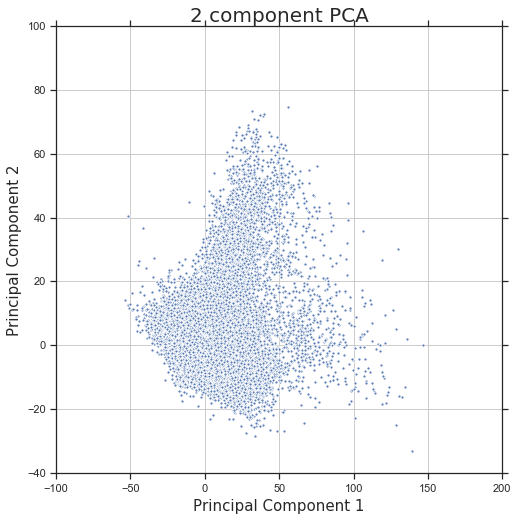

In [29]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(finalDf.loc[:, 'principal component 1']
           , finalDf.loc[:, 'principal component 2']
           , c = 'b'
           , s = 10
           , alpha = 0.9)
ax.grid()
fig.savefig("PCA_scatter.tiff", dpi=350)

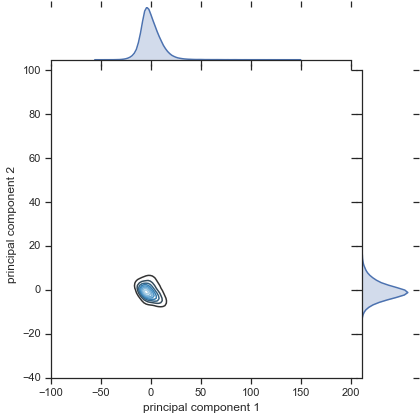

In [30]:
sns.set(style="white", color_codes=True)
snsPlot = sns.JointGrid(x=finalDf["principal component 1"], y=finalDf["principal component 2"], xlim=(-100, 200), ylim=(-40,100))
snsPlot = snsPlot.plot_joint(sns.kdeplot, cmap="Blues_d")
snsPlot = snsPlot.plot_marginals(sns.kdeplot, shade=True)
snsPlot.savefig("PCA_density.tif", dpi = 350)

## Signature node extraction

In [31]:
VAE_encoder = torch.load("VAE_encode_SMGP.pth")
VAE_mu = torch.load("VAE_mu_SMGP.pth")
expLoader = Tdata.DataLoader(dataset = expDatasetSMC)

In [32]:
featureArray = np.zeros((expDataSMC.shape[0], 100))
i = 0
for data in expLoader:
    encoded = VAE_encoder(data[0])
    encoded = VAE_mu(encoded)
    featureArray[i,] = encoded.data.numpy()
    i += 1
print(featureArray.shape)

(12079, 100)


### Plot the heatmap of the top hidden layer of SMGP-trained VAE for random sample

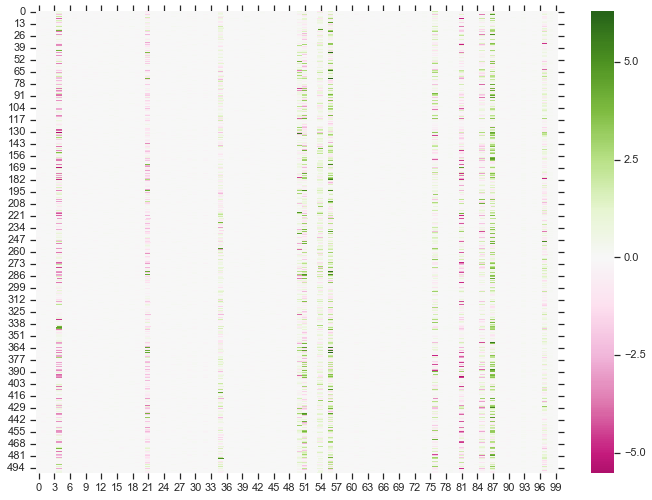

In [33]:
idx = np.random.permutation(expDataSMC.shape[0])
subFeatureArray = featureArray[idx[:500],]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(subFeatureArray, cmap="PiYG", center = 0)
plt.savefig("toplayer.tif", dpi = 350)

### Identify signature node

In [34]:
meanAbs = np.mean(abs(featureArray), axis = 0)
sigNodeSet = set()
for i in range(100):
    if meanAbs[i] > 0.5:
        sigNodeSet.add(i)
sigNodeIndexArray = np.array(sorted(sigNodeSet))
print(sigNodeIndexArray)

[ 4 21 35 50 51 54 56 76 81 85 87 97]


### Signature node heatmap for major PCL

In [35]:
rePertClassTargetDicSM = {}
for p in pertClassTargetDicSM:
    rePertClassTargetDicSM[pertClassTargetDicSM[p]] = p

In [36]:
tempPertCountDic = {}
for p in pertClassTargetArraySM:
    c = tempPertCountDic.setdefault(p, 0)
    tempPertCountDic[p] = c + 1

In [37]:
includePertIndexDic = {}
tempCount = 0
for p in tempPertCountDic:
    if tempPertCountDic[p] >= 150:
        includePertIndexDic[p] = tempPertCountDic[p]
        tempCount += tempPertCountDic[p]
print(len(includePertIndexDic), tempCount)

(21, 8328)


In [38]:
majorPclHeatmap = np.zeros((len(includePertIndexDic), len(sigNodeSet)))
pclColName = []
mIndex = 0
for p, _ in sorted(includePertIndexDic.items(), key = operator.itemgetter(1), reverse = True):
    subFeatureArray = np.zeros((includePertIndexDic[p], len(sigNodeSet)))
    tempIndex = 0
    for i in range(len(pertClassTargetArraySM)):
        if p == pertClassTargetArraySM[i]:
            subFeatureArray[tempIndex,] = featureArray[i,sigNodeIndexArray]
            tempIndex += 1
    print(rePertClassTargetDicSM[p], tempIndex)
    pclColName.append(rePertClassTargetDicSM[p])
    majorPclHeatmap[mIndex,] = np.mean(subFeatureArray, axis = 0)
    mIndex += 1
majorPclHeatmap = pd.DataFrame(majorPclHeatmap, index = pclColName, columns = sigNodeIndexArray)

('CP_PROTEASOME_INHIBITOR', 2352)
('CP_PI3K_INHIBITOR', 531)
('CP_DOPAMINE_RECEPTOR_ANTAGONIST', 504)
('CP_AURORA_KINASE_INHIBITOR', 486)
('CP_EGFR_INHIBITOR', 456)
('CP_MEK_INHIBITOR', 408)
('CP_SRC_INHIBITOR', 354)
('CP_GLUCOCORTICOID_RECEPTOR_AGONIST', 345)
('CP_HDAC_INHIBITOR', 342)
('CP_PDGFR_KIT_INHIBITOR', 332)
('CP_CDK_INHIBITOR', 323)
('CP_TOPOISOMERASE_INHIBITOR', 264)
('CP_RAF_INHIBITOR', 219)
('CP_ESTROGEN_RECEPTOR_AGONIST', 210)
('CP_PPAR_RECEPTOR_AGONIST', 210)
('CP_PARP_INHIBITOR', 201)
('CP_TUBULIN_INHIBITOR', 168)
('CP_RIBONUCLEOTIDE_REDUCTASE_INHIBITOR', 168)
('CP_BROMODOMAIN_INHIBITOR', 155)
('CP_PKC_INHIBITOR', 150)
('CP_MTOR_INHIBITOR', 150)


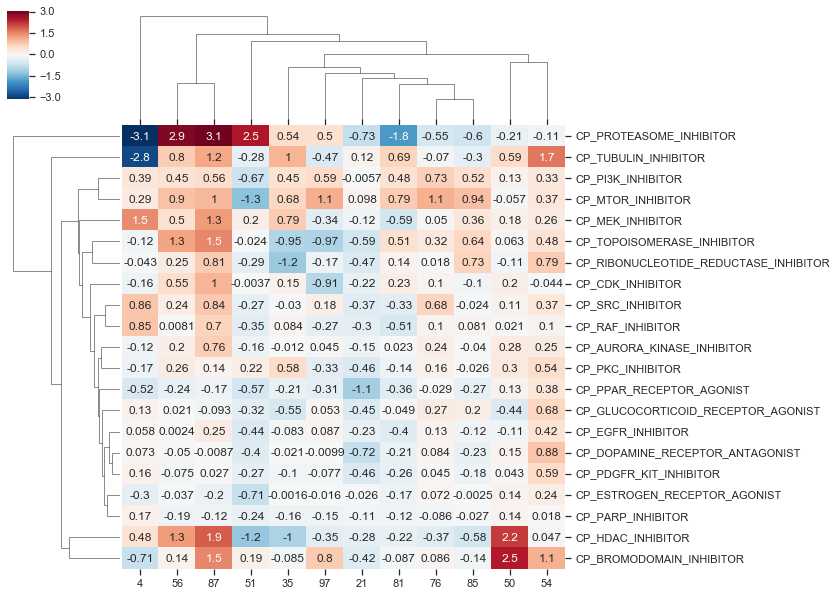

In [39]:
snsPlot = sns.clustermap(majorPclHeatmap, cmap = "RdBu_r", center = 0, annot=True) # other option: metric="correlation"
snsPlot.savefig("signature.tif", dpi = 350)

## Compare the distribution of generated data with real data

In [40]:
useData = 'SM'
if useData == 'SM':
    VAE_encoder = torch.load("VAE_encode_SMP.pth")
    VAE_decoder = torch.load("VAE_decode_SMP.pth")
    VAE_mu = torch.load("VAE_mu_SMP.pth")
    idx = np.random.randint(expDataSMNP.size()[0], size=10000)
    real_data = expDataSMNP.numpy()[idx,]
    real_target = np.ones((real_data.shape[0], 1))
    print(real_data.shape, real_target.shape)
elif useData == 'GP':
    VAE_encoder = torch.load("VAE_encode_GP.pth")
    VAE_decoder = torch.load("VAE_decode_GP.pth")
    VAE_mu = torch.load("VAE_mu_GP.pth")
    idx = np.random.randint(expDataGP.size()[0], size=10000)
    real_data = expDataGP.numpy()[idx,]
    real_target = np.ones((real_data.shape[0], 1))
    print(real_data.shape, real_target.shape)
elif useData == 'both':
    VAE_encoder = torch.load("VAE_encode_SMGP.pth")
    VAE_decoder = torch.load("VAE_decode_SMGP.pth")
    VAE_mu = torch.load("VAE_mu_SMGP.pth")
    idx = np.random.randint(expDataBoth.size()[0], size=10000)
    real_data = expDataBoth.numpy()[idx,]
    real_target = np.ones((real_data.shape[0], 1))
    print(real_data.shape, real_target.shape)
else:
    print("Error! Unidentified type of useData!")

((10000, 978), (10000, 1))


### Generate new data

In [41]:
sample_size = 10000
sample_data = np.zeros((sample_size, 978))
sample_target = np.zeros((sample_size, 1))
for i in range(sample_size):
    z = torch.FloatTensor(100).normal_()
    v = VAE_decoder(z) * 10
    sample_data[i,] = v.data.numpy()
print(sample_data.shape, sample_target.shape)

((10000, 978), (10000, 1))


In [42]:
mix_data = np.concatenate((real_data, sample_data), axis = 0)
mix_target = np.concatenate((real_target, sample_target), axis = 0)
idx = np.random.permutation(20000)
train_data = mix_data[idx[:16000],]
train_target = mix_target[idx[:16000],]
test_data = mix_data[idx[16000:],]
test_target = mix_target[idx[16000:],]
print(train_data.shape, train_target.shape)
print(test_data.shape, test_target.shape)

((16000, 978), (16000, 1))
((4000, 978), (4000, 1))


### PCA plot to visualize distribution

In [43]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(mix_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
targetDf = pd.DataFrame(data = mix_target, columns = ['target'])
finalDf = pd.concat([principalDf, targetDf], axis = 1)
print(finalDf.shape)

(20000, 3)


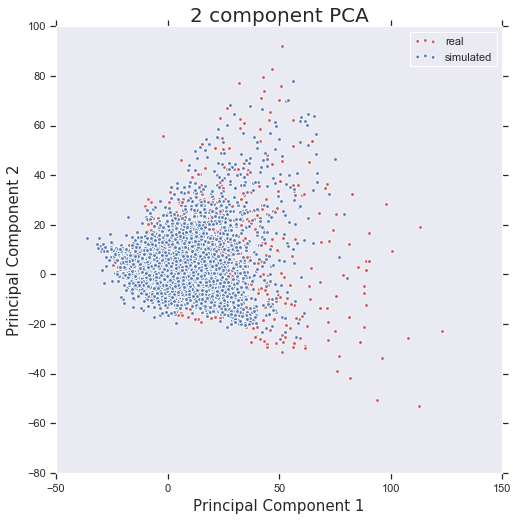

In [44]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
colors = ['r', 'b']
bothData = True

if bothData:
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 15
                  , alpha = 0.9)
    ax.legend(["real", "simulated"])
else:
    indicesToKeep = finalDf['target'] == 1
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = 'r'
               , s = 15
              , alpha = 0.9)
ax.grid()
fig.savefig("PCA_scatter.tiff", dpi=350)

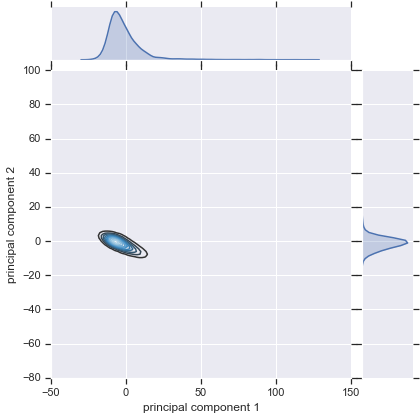

In [47]:
snsPlot = sns.JointGrid(x=finalDf[finalDf["target"]==1]["principal component 1"], y=finalDf[finalDf["target"]==1]["principal component 2"], xlim=(-50,150), ylim=(-80,100))
snsPlot = snsPlot.plot_joint(sns.kdeplot, cmap="Blues_d")
snsPlot = snsPlot.plot_marginals(sns.kdeplot, shade=True)
snsPlot.savefig("PCA_density1.tif", dpi = 350)

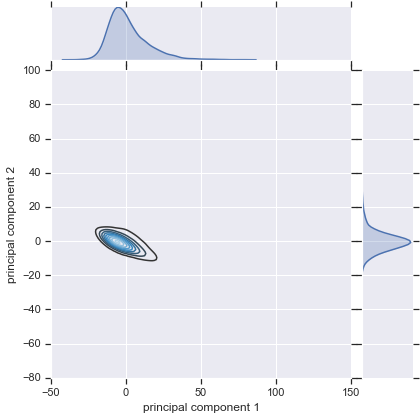

In [48]:
snsPlot = sns.JointGrid(x=finalDf[finalDf["target"]==0]["principal component 1"], y=finalDf[finalDf["target"]==0]["principal component 2"], xlim=(-50,150), ylim=(-80,100))
snsPlot = snsPlot.plot_joint(sns.kdeplot, cmap="Blues_d")
snsPlot = snsPlot.plot_marginals(sns.kdeplot, shade=True)
snsPlot.savefig("PCA_density2.tif", dpi = 350)

## Generate data to simulate real data perturbed by a given PCL

In [49]:
VAE_encoder = torch.load("VAE_encode_SMGP.pth")
VAE_decoder = torch.load("VAE_decode_SMGP.pth")
VAE_mu = torch.load("VAE_mu_SMGP.pth")
tempLoader = Tdata.DataLoader(dataset = expDatasetSMC)
real_data = expDataSMC.numpy()
real_target = np.ones((expDataSMC.size()[0], 1))
print(real_data.shape, real_target.shape)

((12079, 978), (12079, 1))


In [50]:
patternDic = {
    "PROTEASOME_INHIBITOR": {4:-4, 56:3, 87:4, 51:3, 35:1, 97:1, 21:-1, 81:-2, 76:-1, 85:-1},\
    "TUBULIN_INHIBITOR": {4:-4, 56:2, 87:3, 35:2, 81:2, 50:2, 54:3},\
    "PI3K_INHIBITOR": {87:2, 51:-2, 97:2, 76:2, 85:2},\
    "MTOR_INHIBITOR": {56:2, 87:2, 51:-3, 35:3, 97:3, 81:3, 76:3, 85:2},\
    "MEK_INHIBITOR": {4:3, 56:1, 87:3, 35:2, 81:-1},\
    "TOPOISOMERASE_INHIBITOR": {56:3, 87:3, 35:-2, 97:-2, 21:-1, 81:1, 85:2},\
    "RIBONUCLEOTIDE_REDUCTASE_INHIBITOR": {87:2, 35:-3, 85:2, 54:2},\
    "HDAC_INHIBITOR": {56:3, 87:4, 51:-3, 35:-3, 85:-2, 50:3},\
    "BROMODOMAIN_INHIBITOR": {4:-2, 87:3, 97:2, 50:4, 54:2},\
    "Test": {4:5}
}

In [51]:
sigNodeIndexArray = [4, 21, 35, 50, 51, 54, 56, 76, 81, 85, 87, 97, -1, -1]
sigLocDic = {}
for i in range(len(sigNodeIndexArray)):
    sigLocDic[sigNodeIndexArray[i]] = i

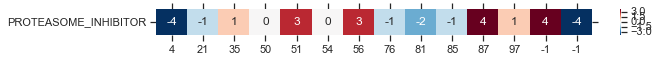

In [52]:
targetPCL = "PROTEASOME_INHIBITOR"
pattern = np.zeros((1, 14))
pattern[0][-2] = 4
pattern[0][-1] = -4
for sig in patternDic[targetPCL]:
    sigLoc = sigLocDic[sig]
    pattern[0][sigLoc] = patternDic[targetPCL][sig]
pattern = pd.DataFrame(pattern, index = [targetPCL], columns = sigNodeIndexArray)
fig, ax = plt.subplots(figsize=(10,1)) 
g = sns.heatmap(pattern, cmap="RdBu_r", center = 0, annot = True)
g.set_yticklabels(g.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.savefig(targetPCL + "_pattern.tif", dpi = 350)

In [53]:
sample_size = 500
sample_data = np.zeros((sample_size, 978))
sample_target = np.zeros((sample_size, 1))
for i in range(sample_size):
    z = torch.FloatTensor(100).normal_()
    for index in patternDic[targetPCL]:
        z[index] = patternDic[targetPCL][index]
    v = VAE_decoder(z) * 10
    sample_data[i,] = v.data.numpy()
print(sample_data.shape, sample_target.shape)

((500, 978), (500, 1))


In [54]:
metric = scipy.spatial.distance.cdist(sample_data, real_data)
minDist = np.argmin(metric, 1)
sigSM = gctoo_cellLineSMC.data_df.transpose().index.values
pertNameDic = {}
temppclDic = {}
for index in minDist:
    sig = sigSM[index]
    pertName = cellLineInfoSM['pert_iname'][cellLineInfoSM['sig_id'] == sig].values[0]
    pert = cellLineInfoSM[cellLineInfoSM["sig_id"] == sig]["pert_id"].values[0]
    if pert in pertClassDicSM:
        pertClass = pertClassDicSM[pert]
        c = temppclDic.setdefault(pertClass, 0)
        temppclDic[pertClass] = c + 1
    c = pertNameDic.setdefault(pertName, 0)
    pertNameDic[pertName] = c + 1
print("The number of PCL: " + str(len(temppclDic)))
print("The number of pert: " + str(len(pertNameDic)))
print('')
for t in sorted(temppclDic.items(), key = operator.itemgetter(1), reverse = True):
    print(t)
print('')
for t in sorted(pertNameDic.items(), key = operator.itemgetter(1), reverse = True):
    print(t)

The number of PCL: 1
The number of pert: 1

('CP_PROTEASOME_INHIBITOR', 500)

('MG-132', 500)


#### Double check

In [55]:
matchData = expDataSMC.numpy()
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(matchData)
distances, indices = nbrs.kneighbors(sample_data)
tempPertDic = {}
for i in indices:
    sig = gctoo_cellLineSMC.data_df.transpose().index.values[i[0]]
    pertID = cellLineInfoSMC[cellLineInfoSMC["sig_id"] == sig]["pert_id"].values[0]
    c = tempPertDic.setdefault(pertClassDicSM[pertID], 0)
    tempPertDic[pertClassDicSM[pertID]] = c + 1
print(sorted(tempPertDic.items(), key = operator.itemgetter(1), reverse = True))

[('CP_PROTEASOME_INHIBITOR', 500)]


### Pie chart

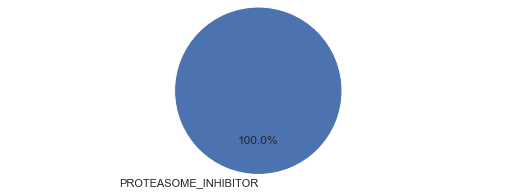

In [57]:
countList = sorted(tempPertDic.items(), key = operator.itemgetter(1), reverse = True)
sizes = []
labels = []
explode = []
for pcl, count in countList:
    if count/sample_size < 0.05:
        break
    sizes.append(count)
    labels.append(pcl[3:])
    if pcl[3:] == targetPCL:
        explode.append(0.1)
    else:
        explode.append(0)
if sum(sizes) < sample_size:
    sizes.append(sample_size - sum(sizes))
    labels.append("Other")
    explode.append(0)
fig1, ax1 = plt.subplots(figsize = (9, 3))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
fig1.savefig(targetPCL + "_pie.tiff", dpi=350)

## PCL Classification

In [58]:
useData = 'both'
if useData == 'SM':
    VAE_encoder = torch.load("VAE_encode_SMP.pth")
    VAE_decoder = torch.load("VAE_decode_SMP.pth")
    VAE_mu = torch.load("VAE_mu_SM.pth")
elif useData == 'both':
    VAE_encoder = torch.load("VAE_encode_SMGP.pth")
    VAE_decoder = torch.load("VAE_decode_SMGP.pth")
    VAE_mu = torch.load("VAE_mu_SMGP.pth")
else:
    print("Error! Unidentified type of useData!")

In [59]:
real_data = expDataSMC.numpy()
real_PCL_target = pertClassTargetSM.numpy()
print(real_data.shape, real_PCL_target.shape)

((12079, 978), (12079,))


### Below two blocks are optional dependent on whether want to only include major PCLs

In [60]:
tempPertCountDic = {}
for p in real_PCL_target:
    c = tempPertCountDic.setdefault(p, 0)
    tempPertCountDic[p] = c + 1
rowCount = 0
tempSet = set()
for p in tempPertCountDic:
    if tempPertCountDic[p] >= 100 and p not in {26,43,15,10,11}:
        rowCount += tempPertCountDic[p]
        tempSet.add(p)
print("The number of major PCL with more than 100 samples: " + str(len(tempSet)))
print("The number of samples with major PCL: " + str(rowCount))

The number of major PCL with more than 100 samples: 25
The number of samples with major PCL: 7698


In [61]:
M = real_data.shape[0]
N = real_data.shape[1]
tempLabel = np.zeros((rowCount,))
tempFeatureArray = np.zeros((rowCount, N))
tempI = 0
reIndex = 0
reIndexDic = {}
for i in range(M):
    p = real_PCL_target[i]
    if p in tempSet:
        if p in reIndexDic:
            p = reIndexDic[p]
        else:
            reIndexDic[p] = reIndex
            reIndex += 1
            p = reIndexDic[p]
        tempLabel[tempI] = p
        tempFeatureArray[tempI,] = real_data[i,]
        tempI += 1
real_data = tempFeatureArray
real_PCL_target = tempLabel
print(real_data.shape, real_PCL_target.shape)

((7698, 978), (7698,))


### PCL prediction using different representations with Logistic Regression and SVM

In [57]:
sigNodeArray = np.array([4, 21, 35, 50, 51, 54, 56, 76, 81, 85, 87, 97])

10-fold cross-validation

In [66]:
np.random.seed(0)
indices = np.random.permutation(real_data.shape[0])
testSize = real_data.shape[0] // 10
layers = ["raw", "e1", "e2", "e3", "sig", "d2", "d1"]

for layer in layers:
    lrTrain = []
    lrTest = []
    svmTrain = []
    svmTest = []
    for i in range(10):
        print("cross-validation: " + str(i))
        train_mask = np.ones(real_data.shape[0], bool)
        train_mask[testSize * i: testSize * (i + 1)] = False
        test_mask = np.zeros(real_data.shape[0], bool)
        test_mask[testSize * i: testSize * (i + 1)] = True
        train_idx, test_idx = indices[train_mask], indices[test_mask]
        real_data_train, real_data_test = real_data[train_idx,:], real_data[test_idx,:]
        real_PCL_target_train, real_PCL_target_test = real_PCL_target[train_idx], real_PCL_target[test_idx]
        print(real_data_train.shape, real_PCL_target_train.shape)
        print(real_data_test.shape, real_PCL_target_test.shape)
        tmpSet = set()
        for p in real_PCL_target_train:
            tmpSet.add(p)
        print("The number of PCL in the training data: " + str(len(tmpSet)))
        tmpSet = set()
        for p in real_PCL_target_test:
            tmpSet.add(p)
        print("The number of PCL in the test data: " + str(len(tmpSet)))
        if layer == "raw":
            real_data_train_H = np.zeros((real_data_train.shape[0], 978))
            real_data_test_H = np.zeros((real_data_test.shape[0], 978))
        elif layer == "e3":
            real_data_train_H = np.zeros((real_data_train.shape[0], 100))
            real_data_test_H = np.zeros((real_data_test.shape[0], 100))
        elif layer == "sig":
            real_data_train_H = np.zeros((real_data_train.shape[0], len(sigNodeArray)))
            real_data_test_H = np.zeros((real_data_test.shape[0], len(sigNodeArray)))
        else:
            real_data_train_H = np.zeros((real_data_train.shape[0], 1000))
            real_data_test_H = np.zeros((real_data_test.shape[0], 1000))
        for i in range(real_data_train.shape[0]):
            if layer == "raw":
                encoded = torch.Tensor(real_data_train[i,:])
            elif layer == "e1":
                encoded = VAE_encoder[1](VAE_encoder[0](torch.Tensor(real_data_train[i,:])))
            elif layer == "e2":
                encoded = VAE_encoder[1](VAE_encoder[0](torch.Tensor(real_data_train[i,:])))
                encoded = VAE_encoder[3](VAE_encoder[2](encoded))
            elif layer == "e3":
                encoded = VAE_encoder(torch.Tensor(real_data_train[i,:]))
                encoded = VAE_mu(encoded)
            elif layer == "sig":
                encoded = VAE_encoder(torch.Tensor(real_data_train[i,:]))
                encoded = VAE_mu(encoded)[sigNodeArray]
            elif layer == "d2":
                encoded = VAE_encoder(torch.Tensor(real_data_train[i,:]))
                encoded = VAE_mu(encoded)
                encoded = VAE_decoder[1](VAE_decoder[0](encoded))
            else:
                encoded = VAE_encoder(torch.Tensor(real_data_train[i,:]))
                encoded = VAE_mu(encoded)
                encoded = VAE_decoder[1](VAE_decoder[0](encoded))
                encoded = VAE_decoder[3](VAE_decoder[2](encoded))
            real_data_train_H[i,] = encoded.data.numpy()
        for i in range(real_data_test.shape[0]):
            if layer == "raw":
                encoded = torch.Tensor(real_data_test[i,:])
            elif layer == "e1":
                encoded = VAE_encoder[1](VAE_encoder[0](torch.Tensor(real_data_test[i,:])))
            elif layer == "e2":
                encoded = VAE_encoder[1](VAE_encoder[0](torch.Tensor(real_data_test[i,:])))
                encoded = VAE_encoder[3](VAE_encoder[2](encoded))
            elif layer == "e3":
                encoded = VAE_encoder(torch.Tensor(real_data_test[i,:]))
                encoded = VAE_mu(encoded)
            elif layer == "sig":
                encoded = VAE_encoder(torch.Tensor(real_data_test[i,:]))
                encoded = VAE_mu(encoded)[sigNodeArray]
            elif layer == "d2":
                encoded = VAE_encoder(torch.Tensor(real_data_test[i,:]))
                encoded = VAE_mu(encoded)
                encoded = VAE_decoder[1](VAE_decoder[0](encoded))
            else:
                encoded = VAE_encoder(torch.Tensor(real_data_test[i,:]))
                encoded = VAE_mu(encoded)
                encoded = VAE_decoder[1](VAE_decoder[0](encoded))
                encoded = VAE_decoder[3](VAE_decoder[2](encoded))
            real_data_test_H[i,] = encoded.data.numpy()
        clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(real_data_train_H, real_PCL_target_train)
        lrTrain.append(clf.score(real_data_train_H, real_PCL_target_train))
        lrTest.append(clf.score(real_data_test_H, real_PCL_target_test))
        clf = LinearSVC(random_state=0).fit(real_data_train_H, real_PCL_target_train)
        svmTrain.append(clf.score(real_data_train_H, real_PCL_target_train))
        svmTest.append(clf.score(real_data_test_H, real_PCL_target_test))
    print(layer, np.mean(lrTrain), np.mean(lrTest), np.mean(svmTrain), np.mean(svmTest))
    print("")

cross-validation: 0
((10872, 978), (10872,))
((1207, 978), (1207,))
The number of PCL in the training data: 75
The number of PCL in the test data: 75
cross-validation: 1
((10872, 978), (10872,))
((1207, 978), (1207,))
The number of PCL in the training data: 75
The number of PCL in the test data: 75
cross-validation: 2
((10872, 978), (10872,))
((1207, 978), (1207,))
The number of PCL in the training data: 75
The number of PCL in the test data: 74
cross-validation: 3
((10872, 978), (10872,))
((1207, 978), (1207,))
The number of PCL in the training data: 75
The number of PCL in the test data: 75
cross-validation: 4
((10872, 978), (10872,))
((1207, 978), (1207,))
The number of PCL in the training data: 75
The number of PCL in the test data: 75
cross-validation: 5
((10872, 978), (10872,))
((1207, 978), (1207,))
The number of PCL in the training data: 75
The number of PCL in the test data: 75
cross-validation: 6
((10872, 978), (10872,))
((1207, 978), (1207,))
The number of PCL in the trainin

## Drug-target prediction

In [63]:
VAE_encoder = torch.load("VAE_encode_SMGP.pth")
VAE_decoder = torch.load("VAE_decode_SMGP.pth")
VAE_mu = torch.load("VAE_mu_SMGP.pth")
sigNodeArray = np.array([4, 21, 35, 50, 51, 54, 56, 76, 81, 85, 87, 97])

### Read in true drug-target

In [64]:
padonFile = "../Data/DrugTarget_Pabon.csv"
rowIndex = -1
chemGeneDic = {}
geneChemDic = {}
with open(padonFile, 'r') as myfile:
    for line in myfile:
        if rowIndex == -1:
            rowIndex += 1
            continue
        rowIndex += 1
        line = line.strip()
        spline = line.split(',')
        chemName = spline[0].lower()
        #chemName = 'BRD-' + spline[1]
        geneName = spline[2]
        chemGeneDic.setdefault(chemName, {})
        chemGeneDic[chemName][geneName] = 1
        geneChemDic.setdefault(geneName, {})
        geneChemDic[geneName][chemName] = 1
print("The number of records in the file: " + str(rowIndex))
print("The number of chems: " + str(len(chemGeneDic)))
print("The number of genes: " + str(len(geneChemDic)))

The number of records in the file: 63
The number of chems: 23
The number of genes: 28


### Drug-target prediction with different representations

In [66]:
nNei = expDataGP.shape[0]
for drug in chemGeneDic:
    infoDrug = cellLineInfoSM[cellLineInfoSM["pert_iname"] == drug]
    indexList = []
    if infoDrug.shape[0] != 0:
        drugSig = infoDrug["sig_id"]
        drugData = parse(L1000FileNameSM, cid = drugSig, rid = lmInfoSM)
        drugData = drugData.data_df.transpose().values.astype(np.float32)
        #h = VAE_encoder[1](VAE_encoder[0](torch.Tensor(drugData)))
        h = VAE_encoder(torch.Tensor(drugData))
        h = VAE_mu(h)
        #h = h [:,sigNodeArray]
        #h = VAE_decoder[1](VAE_decoder[0](h))
        #h = VAE_decoder[3](VAE_decoder[2](h))
        drugData = h.data.numpy()
        
        geneData = expDataGP.data.numpy()
        #h = VAE_encoder[1](VAE_encoder[0](torch.Tensor(geneData)))
        h = VAE_encoder(torch.Tensor(geneData))
        h = VAE_mu(h)
        #h = h [:,sigNodeArray]
        #h = VAE_decoder[1](VAE_decoder[0](h))
        #h = VAE_decoder[3](VAE_decoder[2](h))
        geneData = h.data.numpy()
        
        nbrs = NearestNeighbors(n_neighbors=nNei, algorithm='brute', metric = 'correlation').fit(geneData)
        distances, indices = nbrs.kneighbors(drugData)
        for i in range(indices.shape[0]):
            for j in range(nNei):
                ind = indices[i][j]
                if cellLinePertGP[ind] in chemGeneDic[drug]:
                    indexList.append(j)
                    break
        print(drug, sorted(indexList)[:10], np.mean(indexList))
        print("")

('pitavastatin', [0, 10, 12, 18, 22, 50, 54, 55, 56, 71], 806.8095238095239)

('bortezomib', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 65.69089354424968)

('hydrocortisone', [11, 45, 47, 71, 72, 89, 170, 204, 207, 224], 3019.0714285714284)

('vemurafenib', [0, 0, 0, 0, 1, 1, 1, 1, 1, 2], 779.8024691358024)

('flutamide', [77, 781, 844, 1152, 1874, 2291, 2578, 3421, 3892, 4142], 9172.0)

('clobetasol', [6, 151, 155, 289, 572, 768, 904, 910, 920, 960], 5060.952380952381)

('digoxin', [29, 34, 43, 48, 158, 180, 181, 193, 210, 212], 497.85714285714283)

('mycophenolate-mofetil', [27, 58, 65, 122, 150, 213, 280, 373, 374, 612], 6630.0)

('dasatinib', [4, 8, 12, 14, 26, 31, 32, 36, 50, 62], 681.3823529411765)

('amlodipine', [110, 764, 1292, 1451, 1891, 2112, 2150, 2371, 2545, 2649], 5252.714285714285)

('calcitriol', [660, 984, 1016, 1298, 1504, 1514, 1730, 1864, 2105, 2450], 5877.142857142857)

('glibenclamide', [578, 792, 908, 1034, 1782, 2172, 2670, 2851, 2856, 3141], 7038.452380952381)

('paclita

## S-VQ-VAE PCL representations correlations

In [67]:
model_embedding = torch.load("S_VQ_VAE_embedding.pth")

In [68]:
embedding = model_embedding.weight.data.numpy()
print(embedding.shape)

(75, 1000)


(75, 75)


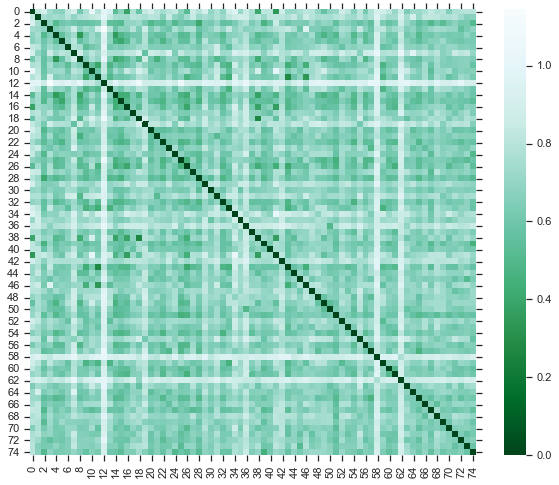

In [69]:
pairwiseDistance = pairwise_distances(embedding, metric = "correlation")
print(pairwiseDistance.shape)
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(pairwiseDistance, cmap="BuGn_r")
plt.savefig("heatmap.tiff", dpi=350)

In [70]:
PCLIndexPertNamedic = {}
for pert in pertClassTargetDicSM:
    PCLIndexPertNamedic[pertClassTargetDicSM[pert]] = pert
outPutFile1 = open("PCL_pairwise_distance_edge_Gephi.csv", 'w')
outPutFile1.write("Source,Target,Type,Weight,Label1,Label2\n")
outPutFile2 = open("PCL_pairwise_distance_node_Gephi.csv", 'w')
outPutFile2.write("Id,Label\n")
tempDistance = np.copy(pairwiseDistance)
tempDistance[tempDistance == 0] = 50
for i in range(tempDistance.shape[0]):
    outPutFile2.write(str(i) + ',' + PCLIndexPertNamedic[i][3:] + '\n')
    j = np.argmin(tempDistance[i])
    print(i, j, PCLIndexPertNamedic[i], PCLIndexPertNamedic[j], np.min(tempDistance[i]))
    outPutFile1.write(str(j) + ',' + str(i) + ',directed,' + str(np.max(tempDistance) - np.min(tempDistance[i])) + ',' + PCLIndexPertNamedic[j][3:] + ',' + PCLIndexPertNamedic[i][3:] + '\n')
outPutFile1.close()
outPutFile2.close()

(0, 41, 'CP_MEK_INHIBITOR', 'CP_SRC_INHIBITOR', 0.34037699326761506)
(1, 25, 'CP_TACHYKININ_ANTAGONIST', 'CP_NFKB_PATHWAY_INHIBITOR', 0.6437465194024612)
(2, 28, 'CP_ESTROGEN_RECEPTOR_AGONIST', 'CP_NOREPINEPHRINE_REUPTAKE_INHIBITOR', 0.40879573033907446)
(3, 72, 'CP_PROTEASOME_INHIBITOR', 'CP_STEROL_DEMETHYLASE_INHIBITOR', 0.5566384653329275)
(4, 8, 'CP_CDK_INHIBITOR', 'CP_TOPOISOMERASE_INHIBITOR', 0.3427062051827716)
(5, 15, 'CP_IKK_INHIBITOR', 'CP_PARP_INHIBITOR', 0.4016654955237723)
(6, 9, 'CP_SODIUM_CHANNEL_BLOCKER', 'CP_HIV_PROTEASE_INHIBITOR', 0.5359064523995658)
(7, 19, 'CP_DNA_POLYMERASE_INHIBITOR', 'CP_BENZODIAZEPINE_RECEPTOR_AGONIST', 0.5673296019612781)
(8, 4, 'CP_TOPOISOMERASE_INHIBITOR', 'CP_CDK_INHIBITOR', 0.3427062051827716)
(9, 11, 'CP_HIV_PROTEASE_INHIBITOR', 'CP_DOPAMINE_RECEPTOR_ANTAGONIST', 0.3977593315352752)
(10, 33, 'CP_PPAR_RECEPTOR_AGONIST', 'CP_DIHYDROFOLATE_REDUCTASE_INHIBITOR', 0.5359893603224788)
(11, 43, 'CP_DOPAMINE_RECEPTOR_ANTAGONIST', 'CP_PDGFR_KIT_INH